***Import library***

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

***Hyper Parameters***

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 8

with open(f'data/threshold by gss.txt', 'r') as f:
    data = f.readlines()
    threshold_list = []
    
    for index in data:
        threshold = tuple(map(float, index.split()))
        threshold_list.append(threshold)
    threshold_list = np.concatenate(threshold_list)
    print(threshold_list)
    
data_size = [100, 300, 600, 900, 1200, 1500]

normal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\abnormal'
AE_PATH = 'CAE_best_model.pth'

[0.00296401 0.00122346 0.00115846 0.00115846 0.00115846 0.00115846]


***Load Datasets***

In [3]:
normal_images = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_images = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
    

labeled_abnormal_images = []
for feature, index in abnormal_images:
    labeled_abnormal_images.append([feature, 1])

***Model***

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5) 
        self.conv3 = nn.Conv2d(12, 24, 4)  
        self.fc1 = nn.Linear(24 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 6 * 110 * 110
        x = self.pool(F.relu(self.conv2(x))) # 12 * 53 * 53
        x = self.pool(F.relu(self.conv3(x))) # 24 * 25 * 25
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))
        
        self.cnn_layer3 = nn.Sequential(
                                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())
        
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())  
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)        
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        output = self.tran_cnn_layer3(output)

        return output
    
AE = ConvAutoEncoder()
AE.load_state_dict(torch.load(AE_PATH))
AE.to(device)

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer3): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  

In [6]:
ae_criterion = nn.MSELoss()
cnn_criterion = nn.CrossEntropyLoss()

***Train & Test***

In [7]:
cnn_err_rate = []
ae_err_rate = []

for number, dsize in enumerate (data_size):
    train_loader = torch.utils.data.DataLoader(normal_images + labeled_abnormal_images[:dsize], batch_size=batch_size)
    CNN_test_loader = torch.utils.data.DataLoader(normal_images + labeled_abnormal_images[:dsize], batch_size=batch_size, shuffle = True)
    CAE_test_loader = torch.utils.data.DataLoader(normal_images + labeled_abnormal_images[:dsize], batch_size=1, shuffle = True)
    
    cnn = CNN()
    CNN_PATH = f"CNN_model/CNN_best_model_{number}.pth"
    cnn.load_state_dict(torch.load(CNN_PATH))
    cnn.to(device)
    print(f"Number of abnormal data : {dsize}")
    
    error = 0
    total = 0
    ##### CNN #####
    for data in CNN_test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        error += (predicted != labels).sum().item()
        
    print(f"CNN error rate : {error / total}")        
    cnn_err_rate.append(error / total)
        

    ae_err = 0    
    ##### CAE #####
    for data in CAE_test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        output = AE(images)
        ae_loss = ae_criterion(images, output)
    
        if labels == 0 and ae_loss.item() > threshold_list[number]:
            ae_err += 1
        elif labels == 1 and ae_loss.item() < threshold_list[number]:
            ae_err += 1
    
    ae_err_rate.append(ae_err / len(CAE_test_loader))
    print(f"AE error rate : {ae_err / len(CAE_test_loader)}\n")       

    with open(f'data/error-rate.txt', 'a') as f:
        f.write(f'{dsize} {error/total} {ae_err / len(CAE_test_loader)}\n')

Number of abnormal data : 100
CNN error rate : 0.655
AE error rate : 0.0

Number of abnormal data : 300
CNN error rate : 0.5
AE error rate : 0.0

Number of abnormal data : 600
CNN error rate : 0.3333333333333333
AE error rate : 0.0022222222222222222

Number of abnormal data : 900
CNN error rate : 0.051666666666666666
AE error rate : 0.0016666666666666668

Number of abnormal data : 1200
CNN error rate : 0.05466666666666667
AE error rate : 0.0013333333333333333

Number of abnormal data : 1500
CNN error rate : 0.16666666666666666
AE error rate : 0.0011111111111111111



***Graph***

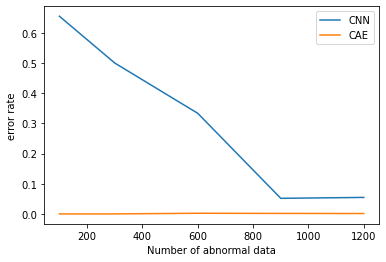

In [9]:
#with open(f'data/error-rate.txt', 'r') as f:
#    data = f.readlines()
#    
#    num_abnormal = []
#    cnn_err_rate = []
#    ae_err_rate = []
#    
#    for index in data:
#        num, cnn, ae = tuple(map(float, index.split()))
#        
#        num_abnormal.append(num)
#        cnn_err_rate.append(cnn)
#        ae_err_rate.append(ae)

plt.plot(data_size[:5], cnn_err_rate[:5], label = 'CNN')
plt.plot(data_size[:5], ae_err_rate[:5], label = 'CAE')
plt.xlabel('Number of abnormal data')
plt.ylabel('error rate')
plt.legend()
plt.show()